# Total Rainfall
 
 


```{glue:figure} accum_rain
:scale: 60%
:align: center
```

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys
import folium

from myst_nb import glue 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize
from ind_setup.tables import plot_df_table, table_rain_a_summary


sys.path.append("../../../functions")
from data_downloaders import GHCN


from data_downloaders import GHCN, download_oni_index
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat
import df2img

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

### Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

### Obervations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

## Analysis

In [6]:
dict_prcp = [{'data' : data, 'var' : 'PRCP', 'ax' : 1, 'label' : 'Precipitation'}, ]

### Plotting

#### Wet days

Wet days are considered when rainfall is above 1mm

In [7]:
data = dict_prcp[0]['data']#.dropna()
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()

glue("n_years", len(np.unique(data.index.year)), display=False)


In [8]:
data['wet_day'] = np.where(data['PRCP'] > 1, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Text(0, 0.5, 'Number of Days')

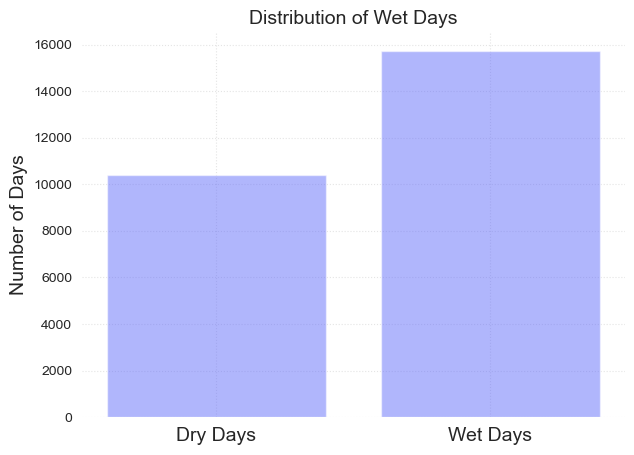

In [9]:
fig, ax = plot_bar_probs(x = [0, 1], y = data.groupby('wet_day').count()['PRCP'].values, labels = ['Dry Days', 'Wet Days'])
ax.set_title('Distribution of Wet Days', fontsize = fontsize)
ax.set_ylabel('Number of Days', fontsize = fontsize)    

#### Accumulated precipitation

The following plot analyzes the accumulated precipitation for each year since 1951.

In [10]:
# Correct accumulated precipitation with number of observations per year to make fair comparisons and trends
datag = (data.groupby(data.index.year).sum()/ data.groupby(data.index.year).count()) * 365
datag.index = pd.to_datetime(datag.index, format = '%Y')
dict_plot = [{'data' : datag, 'var' : 'PRCP', 'ax' : 1, 'label':'Accumulated precipitation [mm]'},]

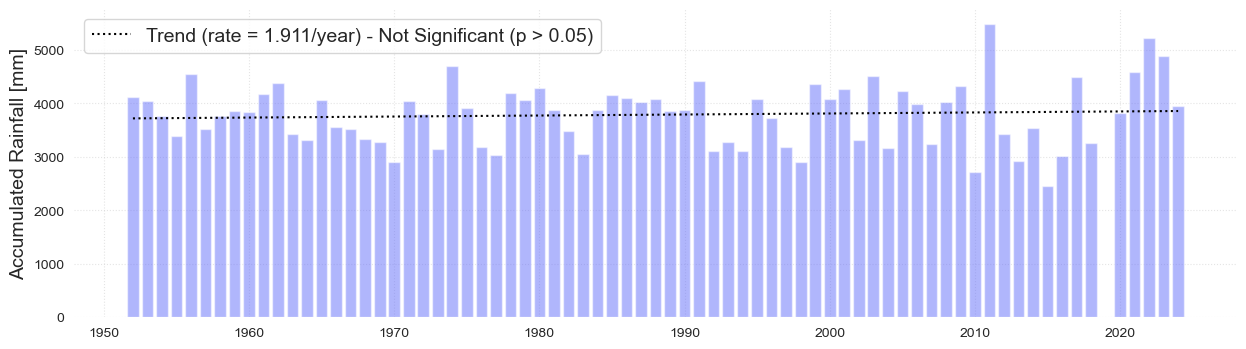

In [11]:
fig, ax = plot_bar_probs(x = datag.index.year, y = datag['PRCP'].values,
                    trendline = True, figsize = [15, 4])
ax.set_ylabel('Accumulated Rainfall [mm]', fontsize = fontsize)
glue("accum_rain", fig, display=False)


#### Number of days over and above 1mm threshold

The following plot analyzes the number of wet (over 1mm) and dry days over time

In [12]:
threshold = 1 #np.percentile(data['PRCP'].dropna(), 90)
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

In [13]:
data_th = data.groupby([data.index.year, data.wet_day_t]).count()['PRCP']
data_th = data_th/data.groupby(data.index.year).count()['PRCP'] * 365

Text(0, 0.5, 'Number of days')

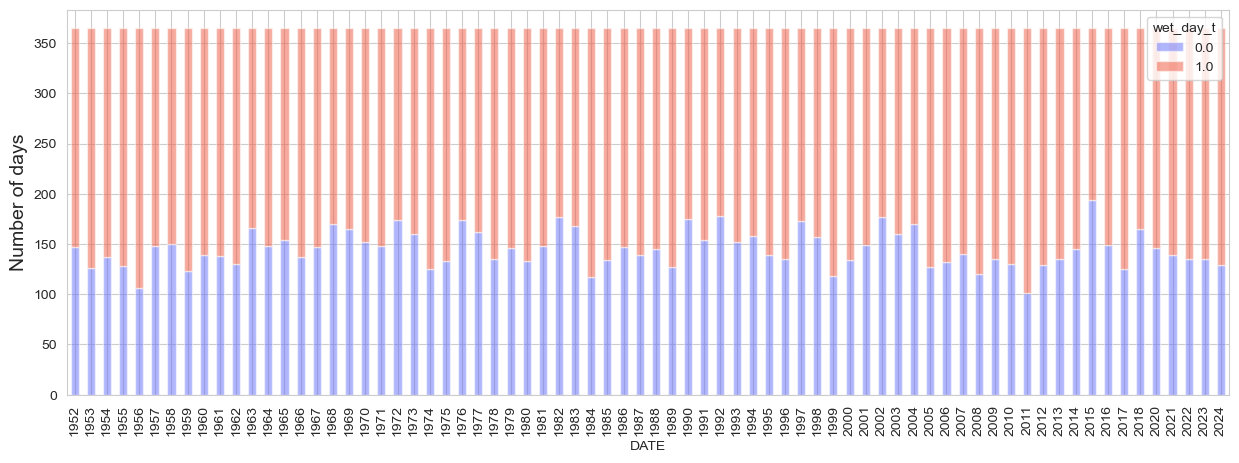

In [14]:
fig, ax = plt.subplots(figsize = [15, 5])
data_th.unstack().plot(kind = 'bar', stacked = True, ax = ax, color = get_df_col()[:2], edgecolor = 'white', alpha = .5)
ax.set_ylabel('Number of days', fontsize = fontsize)

The following plots analyze independently the number of wet and dry days over time as well the trend over time which is not significant in both cases.

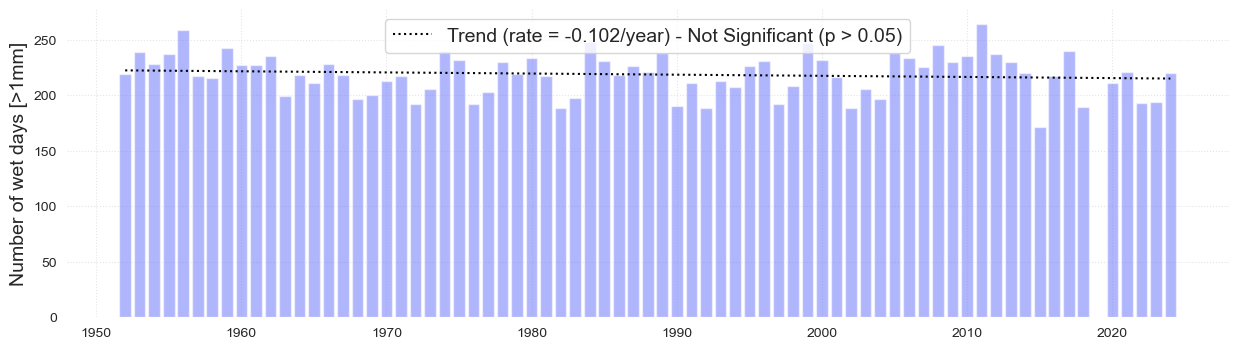

In [15]:
#Wet days
data2 = data.loc[data['wet_day_t'] == 1]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of wet days [>1mm]', figsize = [15, 4], return_trend = True)
plt.savefig(op.join(path_figs, 'F7a_Wet_days_1mm.png'), dpi=300, bbox_inches='tight')
glue("trend_wet", float(trend), display=False)


#### Dry days

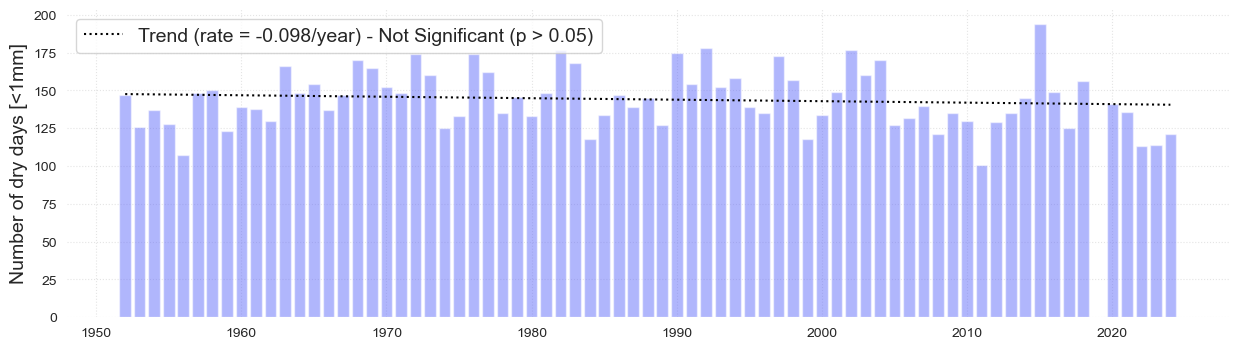

In [16]:
data2 = data.loc[data['wet_day_t'] == 0]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of dry days [<1mm]', figsize = [15, 4], return_trend = True)
plt.savefig(op.join(path_figs, 'F6a_Number_dry.png'), dpi=300, bbox_inches='tight')

glue('trend_dry', float(trend), display=False)


#### Annual maxima

The evolution of the annual maximum precipitation is shown in the following plot.

In [17]:
data_max = data.groupby(data.index.year).max()
data_max.index = pd.to_datetime(data_max.index, format = '%Y')

dict_plot = [{'data' : data_max, 'var' : 'PRCP', 'ax' : 1, 'label':'Annual daily maxima'},]
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12), label_yaxes = 'Precipitation [mm]');

### Table
Table sumarizing different metrics of the data analyzed in the plots above

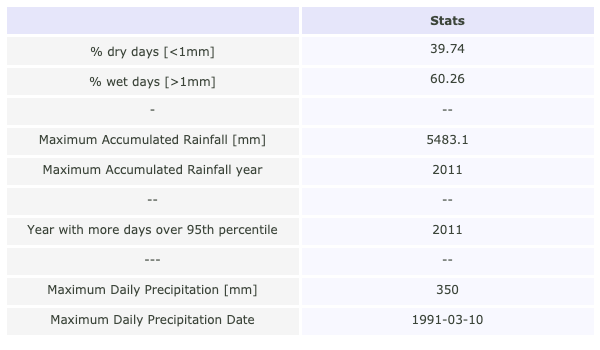

In [18]:
df = table_rain_a_summary(data)
fig = plot_df_table(df.T, figsize = (600, 350),)

## ONI index

The Oceanic Niño Index (ONI) is the standard measure used to monitor El Niño and La Niña events. It is based on sea surface temperature anomalies in the central equatorial Pacific (Niño 3.4 region) averaged over 3-month periods. 

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [19]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [20]:
if update_data:
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

In [21]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

### Analysis

In [22]:
st_data = data
st_data_monthly = st_data.resample('M').mean()
st_data_monthly.index = pd.DatetimeIndex(st_data_monthly.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)

In [23]:
df1['prcp'] = st_data_monthly['PRCP']#.rolling(window=rolling_mean).mean()

In [24]:
df1 = add_oni_cat(df1, lims = lims)

#### Plotting

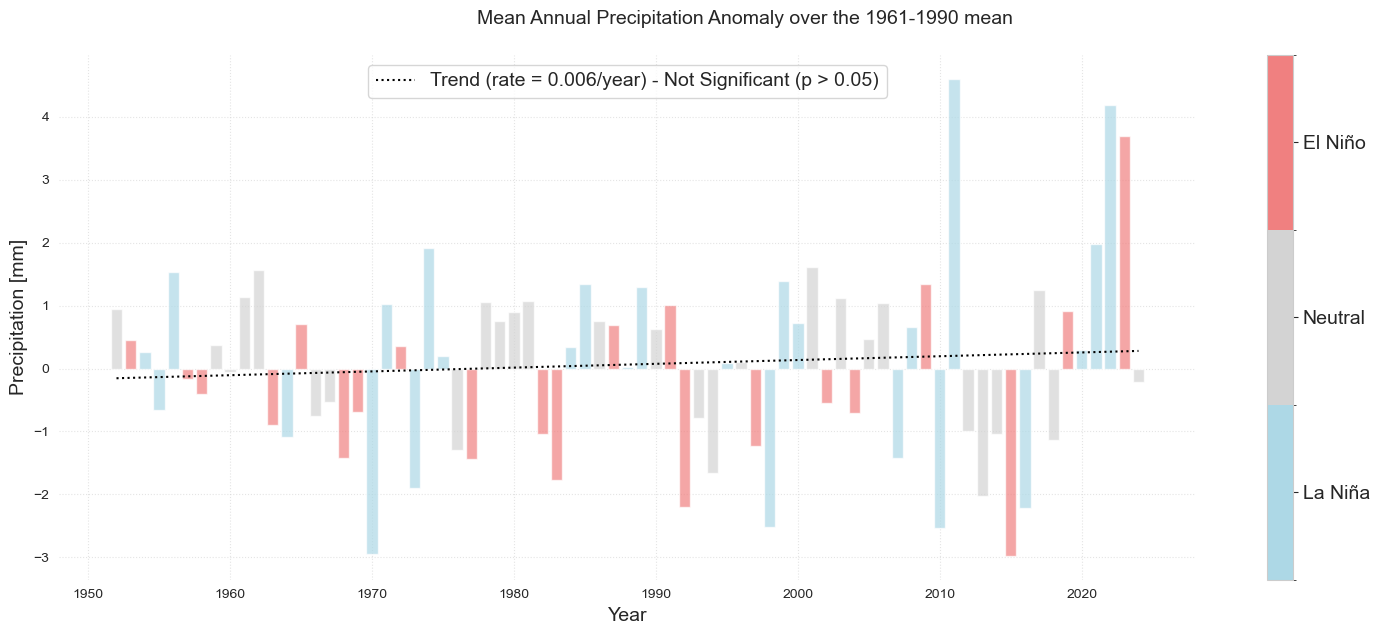

In [25]:
df2 = df1.resample('Y').mean()
df2['prcp_ref'] = df2.prcp - df2.loc['1961':'1990'].prcp.mean()
fig = plot_bar_probs_ONI(df2, var='prcp_ref', y_label = 'Precipitation [mm]')
fig.suptitle('Mean Annual Precipitation Anomaly over the 1961-1990 mean', fontsize = fontsize, y = 1.05)
plt.savefig(op.join(path_figs, 'F5_Rain_mean.png'), dpi=300, bbox_inches='tight')


In [26]:
df_format = np.round(df1.describe(), 2)

### Table
Table sumarizing different metrics of the data analyzed in the plots above

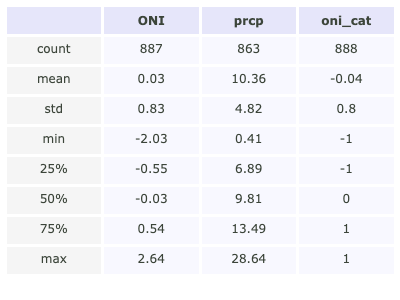

In [27]:
fig = plot_df_table(df_format, figsize = (400, 300))
df2img.save_dataframe(fig=fig, filename="getting_started.png")